# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 48.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.4.0 which is incompatible.


## Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [ ]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [0.00191569 0.02194299 0.0346483  0.01780338]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.00235455 -0.17365828  0.03500437  0.32121375]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## Task 1: Development of an RL agent

Whether or not a state satisfies the 'done' condition depends on the values in the observation space. However, since the values of those states are continuous, the Q_table will be infinitely large if we were to consider every possible combination of states. Hence we can convert these values to discrete representations by separating them into brackets, where each bracket represents a range of continuous values. This is done in the discretizer function below.


In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
from typing import Tuple
n_bins = ( 6 , 12 )
lower_bounds = [ env.observation_space.low[2], -math.radians(50) ]
upper_bounds = [ env.observation_space.high[2], math.radians(50) ]

def discretizer( _ , __ , angle, pole_velocity ) -> Tuple[int,...]:
    """Convert continuous state into a discrete state"""
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds ])
    return tuple(map(int,est.transform([[angle, pole_velocity]])[0]))

n_bins contains all possible combinations of states and env.action_space.n represents the size of the action space, which is 2. The Q_table is created below by combining n_bins with env.action_space.n. Hence, for each possible combination of states there are 2 possible actions. This results in our 3D Q_table that has the dimensions 6 by 12 by 2.


In [ ]:
Q_table = np.zeros(n_bins + (env.action_space.n,))
Q_table.shape
#print(Q_table)

(6, 12, 2)

The policy function below determines the action that the agent will take based on the current state of the environment. It takes the current state of the environment as argument and returns the action with the highest Q value in the Q_table. The new_Q_value function calculates and returns a new Q value based on the rewards received from the environment and the new state reached after each action. 

In [ ]:
def policy( state : tuple ):
    """Choosing action based on epsilon-greedy policy"""
    return np.argmax(Q_table[state])

In [ ]:
def new_Q_value( reward : float ,  new_state : tuple , discount_factor=1 ) -> float:
    """Temperal diffrence for updating Q-value of state-action pair"""
    future_optimal_value = np.max(Q_table[new_state])
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value

to add text for the learning rate and exploration rate

In [ ]:
# Adaptive learning of Learning Rate
def learning_rate(n : int , min_rate=0.01 ) -> float  :
    """Decaying learning rate"""
    return max(min_rate, min(1.0, 1.0 - math.log10((n + 1) / 25)))

In [ ]:
def exploration_rate(n : int, min_rate= 0.1 ) -> float :
    """Decaying exploration rate"""
    return max(min_rate, min(1, 1.0 - math.log10((n  + 1) / 25)))

In this code, we will train the agent using a Q-learning algorithm to learn the optimal policy for the environment. After each action, the agent checks the value of done. If done is True, the agent breaks out of the while loop and starts a new episode. If done is False, the agent continues to select the next action by passing in its current state to the policy function which then returns the action with highest Q value in the Q_table. It then updates the value in the Q_table with the new Q value calculated by the new_q_value function.

In [ ]:
#Q_table = np.zeros(n_bins + (env.action_space.n,))
n_episodes = 700
for e in range(n_episodes):
    
    # Siscretize state into buckets
    current_state, done = discretizer(*env.reset()), False
    
    while done==False:
        
        # policy action 
        action = policy(current_state) # exploit
        #print("Episode", e, "action: ", action)
      
        
        # insert random action
        
        if np.random.random() < exploration_rate(e) : 
            action = env.action_space.sample() # explore
        
         
        # increment enviroment
        obs, reward, done, _ = env.step(action)
        new_state = discretizer(*obs)
        
        # Update Q-Table
        lr = learning_rate(e)
        learnt_value = new_Q_value(reward , new_state )
        old_value = Q_table[current_state][action]
        Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value
        
        current_state = new_state

For Task 1, we can show the observation and chosen action below:

In [ ]:
observation = env.reset()
current_state = discretizer(*env.reset())
action = policy(current_state)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [ 0.0023013  -0.02815234  0.04515775 -0.04008669]
Chosen action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

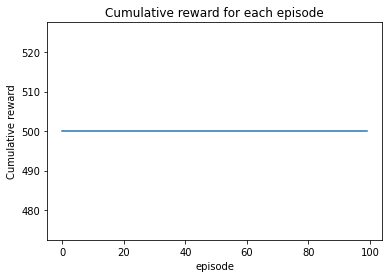

In [ ]:
#episode_results = np.random.randint(150, 250, size=100)

#implement loop to show 100 episodes
y = [0 for i in range(100)]
x = [0 for i in range(100)]
for i in range(100):
  observation = env.reset()
  cumulative_reward = 0
  current_state = discretizer(*env.reset())
  done = False
  while not done:
    #print("Made it in the loop!")
    #action = theta_omega_policy(observation)
    
    action = policy(current_state)
    obs, reward, done, _ = env.step(action)
    new_state = discretizer(*obs)
    #lr = learning_rate(e)
    #learnt_value = new_Q_value(reward , new_state )
    #old_value = Q_table[current_state][action]
    #Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value
        
    current_state = new_state

    #print(action)
    #observation, reward, done, info = env.step(action)
    cumulative_reward = cumulative_reward + reward
  #print("Cumulative reward: ", cumulative_reward)
  x[i] = i
  y[i] = cumulative_reward

plt.plot(x, y)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()
#print(Q_table)

Print the average reward over the 100 episodes.

In [ ]:
total = 0
for i in range(100):
  total = total + y[i]


print("Average cumulative reward:", total/100)
print("Is my agent good enough?", total/100 > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
current_state = discretizer(*env.reset())
while True:
    #your agent goes here
    env.render()
    #action = theta_omega_policy(observation)
    #observation, reward, done, info = env.step(action) 
    #action = rand_policy_agent(observation)

    action = policy(current_state)
    obs, reward, done, _ = env.step(action)
    #print(done)
    if done: 
      break;
    new_state = discretizer(*obs)
    #lr = learning_rate(e)
    #learnt_value = new_Q_value(reward , new_state)
    #old_value = Q_table[current_state][action]
    #Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value


    current_state = new_state

env.close()
show_video()